In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import random 
seed = 202
random.seed(seed)
np.random.seed(seed)

In [3]:
PATH = './'
TRAIN = './train/'
TEST = './test/'
LABELS = './TRAIN.csv'#'./HPAv18RBGY_wodpl.csv'

MOREDATA = './moredata/'
MORELABELS = './rare.csv'

SAMPLE = './sample_submission.csv'

In [4]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [5]:
moredata_names = list(pd.read_csv(MORELABELS)['Id'])
train_names = sorted({f[:36] for f in os.listdir(TRAIN)})
test_names = sorted({f[:36] for f in os.listdir(TEST)})
print('train:',len(train_names),'  test:',len(test_names))
tr_n,val_n = train_test_split(train_names, test_size=0.1, random_state=seed)
tr_n+=moredata_names
print('train:',len(tr_n),'  val:',len(val_n))

train: 31072   test: 11702
train: 35722   val: 3108


In [36]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        self.multi = [1,1,1,1,1,1,1,1,
                      4,4,4,1,1,1,1,4,
                      1,1,1,1,2,1,1,1,
                      1,1,1,4]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(os.path.join(PATH,pd.read_csv('')))
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

38496


In [6]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    try:
        img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
    except:
        img = [cv2.imread(os.path.join(MOREDATA, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
    return np.stack(img, axis=-1)

In [7]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [8]:
def get_data(sz,bs,is_test=False):
    #data augmentation
    if is_test:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    else:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO),
                Cutout(n_holes=25, length=10*sz//128, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    #stats = A([0.05634, 0.05198, 0.03216, 0.09692],[0.0859 , 0.08025, 0.0859 , 0.13703])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md
"""
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    #stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    # Iafoss original RGBY
    #stats = A([0.0804, 0.0526, 0.0547, 0.0827], [0.394, 0.321, 0.327, 0.399])
    # HPAv18 all RGBY (each image is colored RGB png image 512x512)
    stats = A([0.06734, 0.05087, 0.03266, 0.09257],[0.11997, 0.10335, 0.10124, 0.1574 ])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md
"""
#([0.05634, 0.05198, 0.03216, 0.09692],[0.0859 , 0.08025, 0.0859 , 0.13703])

'\ndef get_data(sz,bs):\n    #data augmentation\n    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),\n                RandomDihedral(tfm_y=TfmType.NO),\n                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]\n    #mean and std in of each channel in the train set\n    #stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])\n    # Iafoss original RGBY\n    #stats = A([0.0804, 0.0526, 0.0547, 0.0827], [0.394, 0.321, 0.327, 0.399])\n    # HPAv18 all RGBY (each image is colored RGB png image 512x512)\n    stats = A([0.06734, 0.05087, 0.03266, 0.09257],[0.11997, 0.10335, 0.10124, 0.1574 ])\n    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, \n                aug_tfms=aug_tfms)\n    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), \n                (val_n,TRAIN), tfms, test=(test_names,TEST))\n    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)\n    return md\n'

In [9]:
nw = 2   #number of workers for data loader
arch = resnet34 #specify target architecture

bs = 32
sz = 256
md = get_data(sz,bs,is_test=True)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([32, 4, 256, 256]), torch.Size([32, 28]))

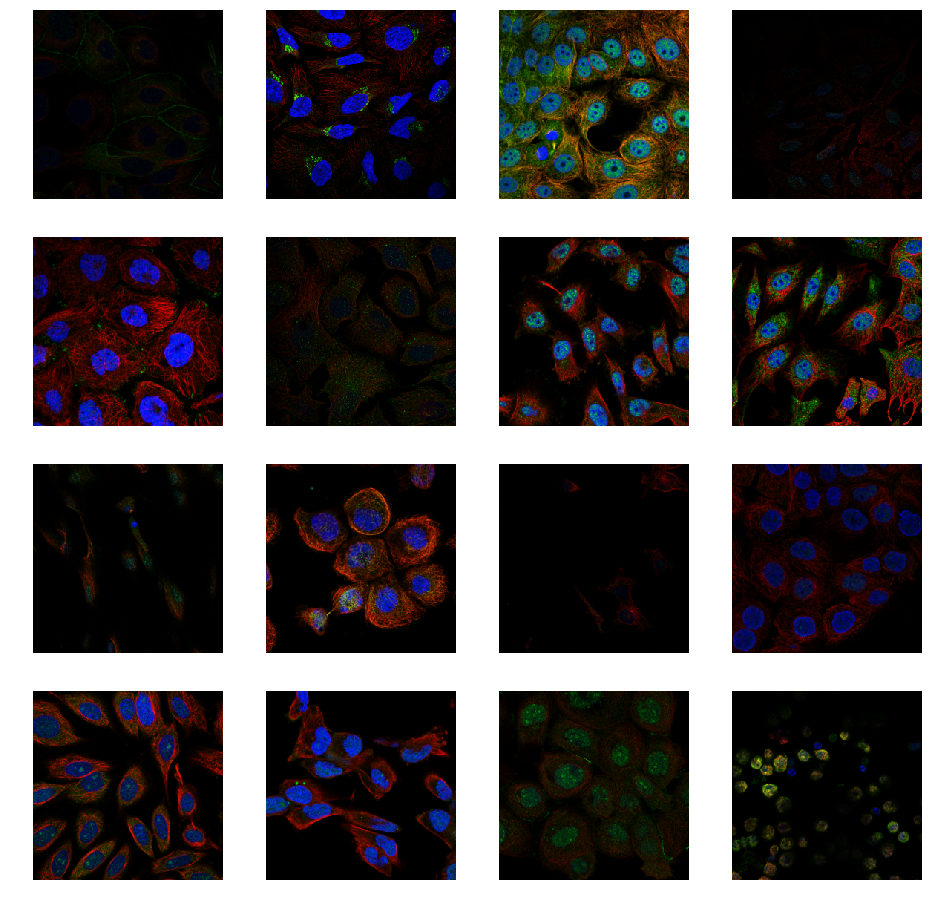

In [10]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [12]:
"""
x_tot = np.zeros(4)
x2_tot = np.zeros(4)
for x,y in tqdm(iter(md.trn_dl)):
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr,channel_std
"""

'\nx_tot = np.zeros(4)\nx2_tot = np.zeros(4)\nfor x,y in tqdm(iter(md.trn_dl)):\n    tmp =  md.trn_ds.denorm(x).reshape(16,-1)\n    x = md.trn_ds.denorm(x).reshape(-1,4)\n    x_tot += x.mean(axis=0)\n    x2_tot += (x**2).mean(axis=0)\n\nchannel_avr = x_tot/len(md.trn_dl)\nchannel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)\nchannel_avr,channel_std\n'

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [12]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [13]:
class F1:
    __name__ = 'F1 macro'
    def __init__(self,n=28):
        self.n = n
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

    def __call__(self,preds,targs,th=0.0):
        preds = (preds > th).int()
        targs = targs.int()
        self.TP += (preds*targs).float().sum(dim=0)
        self.FP += (preds > targs).float().sum(dim=0)
        self.FN += (preds < targs).float().sum(dim=0)
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6)).mean()
        return score

    def reset(self):
        #macro F1 score
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6))
        print('F1 macro:',score.mean(),flush=True)
        #print('F1:',score)
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

class F1_callback(Callback):
    def __init__(self, n=28):
        self.f1 = F1(n)

    def on_epoch_end(self, metrics):
        self.f1.reset()

In [14]:
from newConvLearner import ConvLearner

sz = 512 #image size
bs = 32  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.models.model = torch.nn.DataParallel(learner.models.model,device_ids=[0, 1])
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
f1_callback = F1_callback()
learner.metrics = [acc,f1_callback.f1]
learner.summary

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


<bound method ConvLearner.summary of DataParallel(
  (module): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

  0%|          | 1/3038 [00:05<5:01:26,  5.96s/it, loss=0.963]

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 1989/3038 [26:32<11:56,  1.46it/s, loss=0.255] 

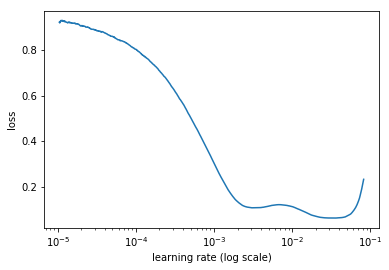

In [16]:
"""
learner.lr_find()
learner.sched.plot()
"""

In [18]:
lr = 0.5e-2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr,1,callbacks=[f1_callback])

SyntaxError: invalid syntax (<ipython-input-18-fa7b1b4dfe03>, line 2)

In [15]:
lr = 0.5e-2
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.3634977828674338                                   
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.849136   0.801177   0.963079   0.357237  
F1 macro: 0.4478233917871095                                   
    1      0.779902   0.681079   0.96871    0.439425  
F1 macro: 0.43225364068557565                                  
    2      0.784442   0.721826   0.966124   0.412371  
F1 macro: 0.5062600956661745                                   
    3      0.734184   0.629984   0.97118    0.491294  
F1 macro: 0.5376938662897179                                   
    4      0.748275   0.668222   0.96933    0.518245  
F1 macro: 0.5336749442563256                                   
    5      0.711395   0.60894    0.971893   0.517926  
F1 macro: 0.5255422650288292                                   
    6      0.742519   0.623067   0.970824   0.499305  
F1 macro: 0.5797090213117465                                   
    7      0.693621   0.584097   0.972571   0.5

In [16]:
learner.load('ResNet18_512_1')

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/16,2,cycle_len=4,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.5749204127494146                                     
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.686672   0.578086   0.972893   0.556387  
F1 macro: 0.5839059338093607                                   
    1      0.680928   0.571332   0.97326    0.559138  
F1 macro: 0.6032831350792882                                   
    2      0.647736   0.562029   0.97303    0.589648  
F1 macro: 0.5967516467196375                                   
    3      0.661692   0.559498   0.973329   0.585263  
F1 macro: 0.5820872773781633                                   
    4      0.656449   0.574025   0.972996   0.574306  
F1 macro: 0.6044996524635607                                   
    5      0.674264   0.559297   0.973364   0.588956  
F1 macro: 0.6041254032711256                                   
    6      0.643679   0.550116   0.973651   0.581923  
F1 macro: 0.621194822727938                                    
    7      0.647062   0.549483   0.973697   0

In [16]:
learner.load('ResNet34_512_1')

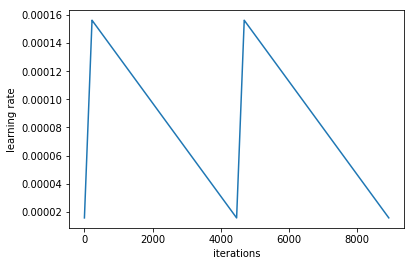

In [19]:
learner.sched.plot_lr()

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/32,2,cycle_len=4,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.28481403398717325                                  
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.97135    3289.964021 0.925549   0.290538  
F1 macro: 0.4005754609966528                                   
    1      0.949639   12.873877  0.965262   0.411472  
F1 macro: 0.4112189127764558                                   
    2      0.936886   2304.041532 0.962597   0.412032  
F1 macro: 0.2685997292219569                                   
    3      0.927323   12833.360543 0.919539   0.269374  
F1 macro: 0.3804521142386938                                   
    4      0.954893   52.74404   0.956518   0.397277  
F1 macro: 0.4036635942652142                                   
    5      0.907879   679.893012 0.963309   0.419007  
F1 macro: 0.3769382443957792                                   
    6      0.905657   156.03378  0.958368   0.387358  
F1 macro: 0.40058457274610976                                  
    7      0.921435   342.383002 0.961792  

In [18]:
learner.save('ResNet34_512_2')

In [26]:
md = get_data(sz,bs,is_test=True)
learner.set_data(md)
preds,y = learner.TTA(n_aug=8)
preds = np.stack(preds, axis=-1)
pred = preds.mean(axis=-1)

In [27]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [28]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [-0.21927 -0.08223 -0.01133 -0.28438 -0.28923 -0.37616 -0.24697 -0.04389 -0.2521  -0.46224 -0.05074 -0.36636
  0.02665 -0.11339 -0.09003  0.      -0.48819 -0.02431 -0.30545  0.01587 -0.09818 -0.44091 -0.10548 -0.14259
 -0.00249 -0.20425 -0.26926  0.     ]
F1 macro:  0.6765142866337245
F1 macro (th = 0.0):  0.652390649639455
F1 micro:  0.7782669601761055


/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [29]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score += f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Thresholds:  [-0.19578 -0.08944 -0.02737 -0.03033 -0.2448  -0.12127 -0.21995 -0.13012 -0.16021 -0.37275 -0.04146 -0.06277
  0.01076 -0.02448 -0.08331  0.      -0.28746  0.07781 -0.34223  0.0047  -0.10134 -0.32112 -0.08921 -0.23978
 -0.08968 -0.21433 -0.22855  0.     ]
F1 macro avr: 0.6436916782237024
F1 macro:  0.665249857238334
F1 micro:  0.7748733535967578


In [30]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Fractions:  [0.46268 0.03571 0.10553 0.03668 0.04987 0.06371 0.02638 0.09041 0.00161 0.00129 0.00097 0.02445 0.01448
 0.0103  0.03089 0.      0.00772 0.00418 0.03411 0.03668 0.00354 0.10779 0.01866 0.08945 0.00676 0.29794
 0.0045  0.00032]
Fractions (true):  [0.4231  0.03829 0.1184  0.04665 0.05631 0.07754 0.03378 0.09878 0.00193 0.00161 0.00097 0.03185 0.01931
 0.01609 0.03346 0.00064 0.01737 0.00676 0.02767 0.0444  0.00579 0.11937 0.02445 0.09749 0.00644 0.25257
 0.00804 0.     ]


/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Nucleoplasm 0 0.8579731202324736 -0.19577796618479604


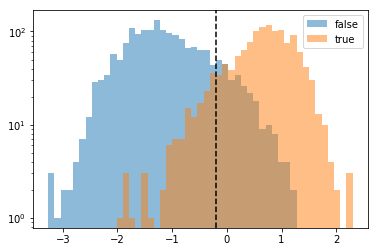

Nuclear membrane 1 0.8869565217391304 -0.08943574191182216


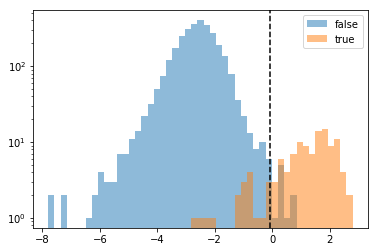

Nucleoli 2 0.8275862068965518 -0.027368475216768516


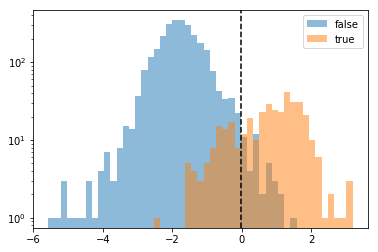

Nucleoli fibrillar center 3 0.7490347490347491 -0.03033414896704459


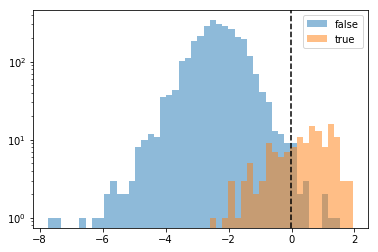

Nuclear speckles 4 0.7818181818181819 -0.2447979793403449


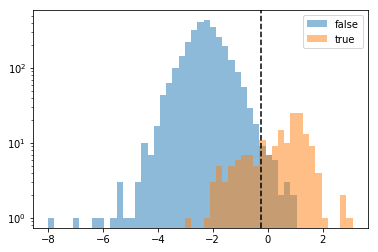

Nuclear bodies 5 0.7015945330296127 -0.1212655067853982


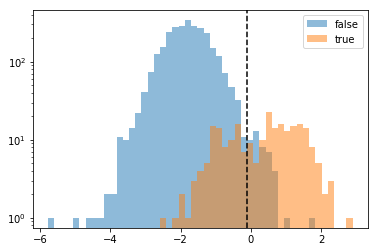

Endoplasmic reticulum 6 0.6310160427807486 -0.21994725234596216


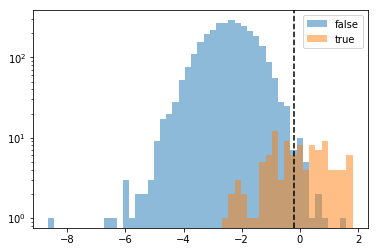

Golgi apparatus 7 0.8299319727891157 -0.1301228824903779


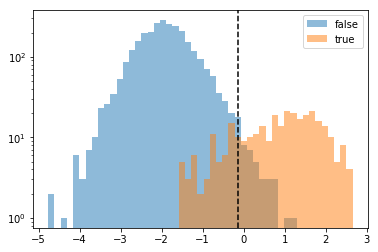

Peroxisomes 8 0.5454545454545454 -0.16021007204090842


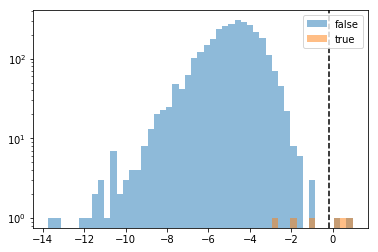

Endosomes 9 0.888888888888889 -0.3727496639190139


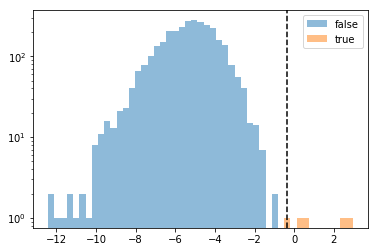

Lysosomes 10 1.0 -0.04146331423883844


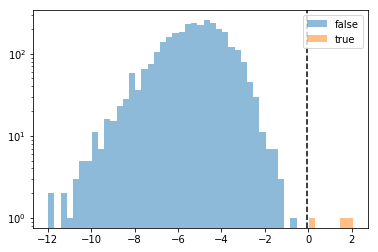

Intermediate filaments 11 0.7771428571428571 -0.06277444547549857


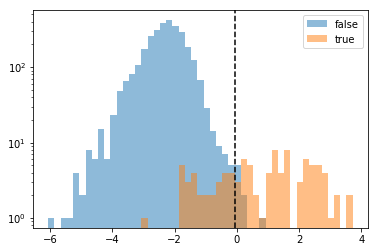

Actin filaments 12 0.8 0.01075565095388099


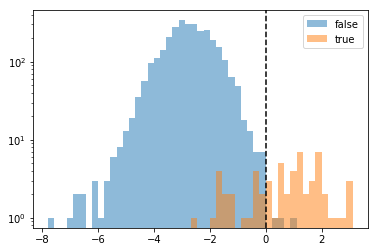

Focal adhesion sites 13 0.7560975609756097 -0.024479083271001307


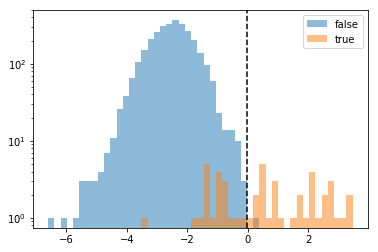

Microtubules 14 0.86 -0.08330987434075587


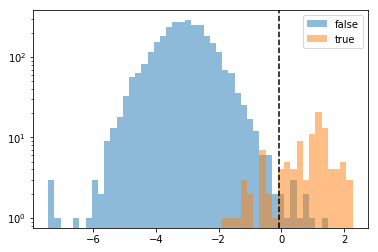

Microtubule ends 15 0.0 0.0


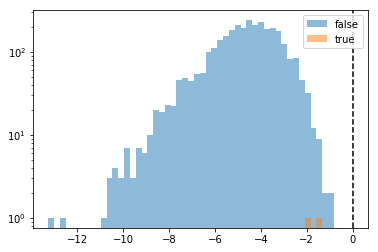

Cytokinetic bridge 16 0.43589743589743596 -0.2874582363803556


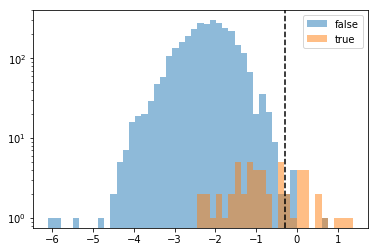

Mitotic spindle 17 0.35294117647058826 0.07781111982005917


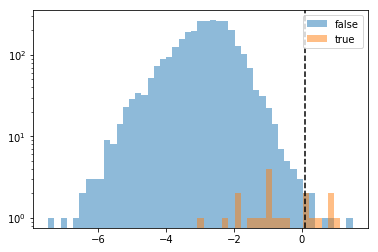

Microtubule organizing center 18 0.5833333333333333 -0.3422311637279228


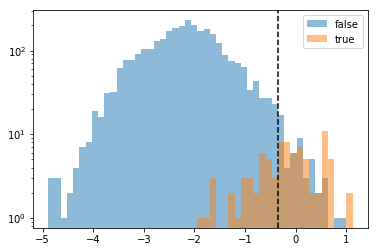

Centrosome 19 0.6587301587301587 0.004697907080436356


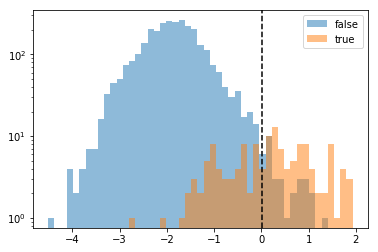

Lipid droplets 20 0.6896551724137931 -0.10134117005321179


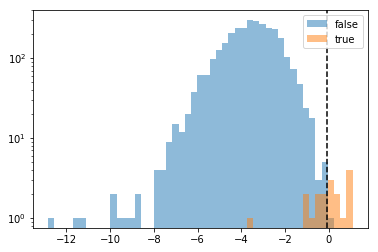

Plasma membrane 21 0.71671388101983 -0.3211201652440142


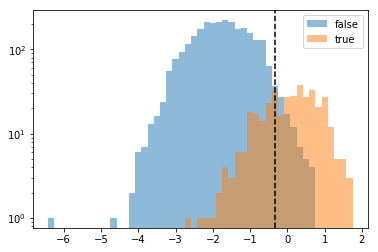

Cell junctions 22 0.671641791044776 -0.0892058559256945


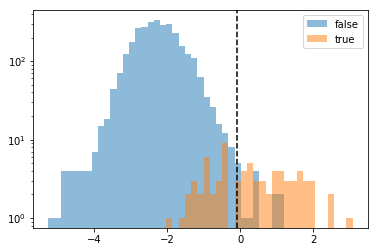

Mitochondria 23 0.8227194492254732 -0.23977861688635457


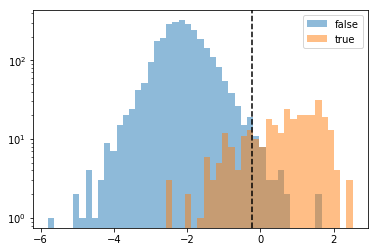

Aggresome 24 0.5853658536585366 -0.08968292282679828


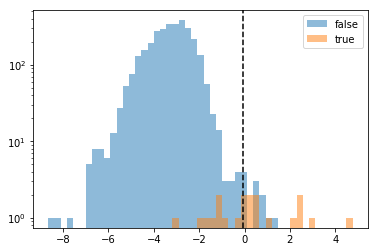

Cytosol 25 0.7036820572764465 -0.2143336969646182


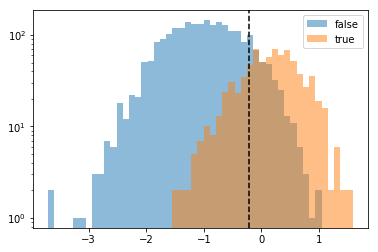

Cytoplasmic bodies 26 0.5128205128205129 -0.2285507955459166


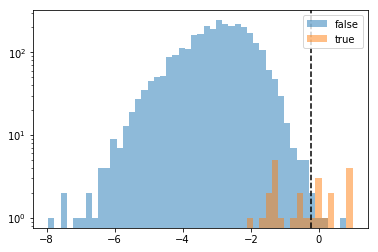

Rods & rings 27 0.0 0.0


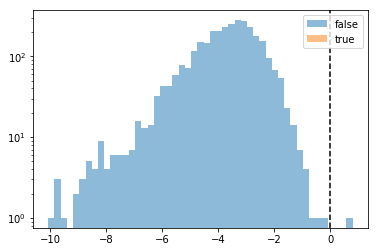

In [31]:
f1 = f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

In [19]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)

In [33]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [34]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.0,'protein_classification_0.csv')

In [35]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [36]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [37]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [ 0.07955 -0.65661  0.04075 -0.88559 -0.94617 -0.58129 -0.78697 -0.23574  0.5     -2.26847 -2.33227 -0.75259
 -0.9543  -0.30613 -0.27585 -1.6581  -0.6938  -0.24033 -0.27553 -0.50801 -0.78404 -0.19875 -0.57289 -0.33217
 -0.42649  0.05624 -1.02592 -1.24705]
Fractions:  [0.36182 0.04367 0.0752  0.05905 0.07537 0.0752  0.04401 0.07537 0.00051 0.00974 0.01008 0.04358 0.04375
 0.01419 0.04384 0.00991 0.02888 0.01384 0.02888 0.05905 0.01008 0.12622 0.0288  0.07486 0.00991 0.2209
 0.02854 0.01   ]
Fractions (th = 0.0):  [0.38258 0.03153 0.07751 0.02769 0.03281 0.04042 0.01581 0.05888 0.00051 0.00085 0.0006  0.02581 0.01658
 0.01111 0.03606 0.00034 0.00812 0.01025 0.01598 0.02965 0.00325 0.08998 0.01436 0.05726 0.00769 0.24962
 0.00504 0.00103]


In [38]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [39]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [40]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([40958.,  3072., 10871.,  3329.,  5130.,  5938.,  3725.,  9405.,   217.,   197.,   182.,  2194.,
         2233.,  1458.,  2692.,    63.,  1290.,   446.,  1893.,  3672.,   438., 13809.,  2729., 10345.,
          428., 37366.,   706.,   127.]),
 array([0.38757, 0.02907, 0.10287, 0.0315 , 0.04854, 0.05619, 0.03525, 0.089  , 0.00205, 0.00186, 0.00172,
        0.02076, 0.02113, 0.0138 , 0.02547, 0.0006 , 0.01221, 0.00422, 0.01791, 0.03475, 0.00414, 0.13067,
        0.02582, 0.09789, 0.00405, 0.35358, 0.00668, 0.0012 ]))

In [41]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [-0.01626  0.15923 -0.36783 -0.18581 -0.5818  -0.3337  -0.65538 -0.41014  0.5     -1.05599 -1.24417  0.30977
 -0.32223 -0.28137  0.51241 -0.23899 -0.26125  0.55342 -0.04867 -0.11705 -0.15503 -0.22353 -0.4942  -0.6131
  1.19926 -0.20898 -0.19056 -0.11753]
Fractions:  [0.38711 0.02914 0.10314 0.03145 0.04862 0.05649 0.03512 0.08879 0.00051 0.00188 0.00171 0.02059 0.02111
 0.01367 0.02538 0.0006  0.01213 0.00419 0.01786 0.03478 0.00419 0.13049 0.02581 0.09759 0.00402 0.35413
 0.00675 0.00128]
